In [1]:
import random

import gym
import numpy as np
import scipy.stats as st
import matplotlib.pyplot as plt

from gym import spaces
from gym.utils import seeding
from gym.envs.toy_text.blackjack import BlackjackEnv
from tqdm import tqdm
from matplotlib import pyplot
%matplotlib inline
plt.style.use('ggplot')

## Часть первая, с блекджеком и стратегиями

1) Рассмотрим очень простую стратегию: говорить stand, если у нас на руках комбинация в 19, 20 или 21 очко, во всех остальных случаях говорить hit. Используйте методы Монте-Карло, чтобы оценить выигрыш от этой стратегии.


In [2]:
env = gym.make('Blackjack-v1', natural=True)

In [3]:
def check_state(state):
    return state[0] < 19

def get_experiment(check_state, n=100000):
    rewards = []
    for _ in range(n):
        observation = env.reset()
        done = False
        reward = 0
        result = 0
        while not done:
            step = check_state(observation)
            observation, reward, done, _ = env.step(step)
        rewards.append(reward)
    return rewards

In [4]:
n = 100000
rewards = get_experiment(check_state, n)
print(f'Средний проигрыш при такой стратегии за {n} экспериментов: {np.mean(rewards)}')

Средний проигрыш при такой стратегии за 100000 экспериментов: -0.19907


100%|████████████████████████████████████████████████████████████████████████| 100000/100000 [00:27<00:00, 3595.58it/s]


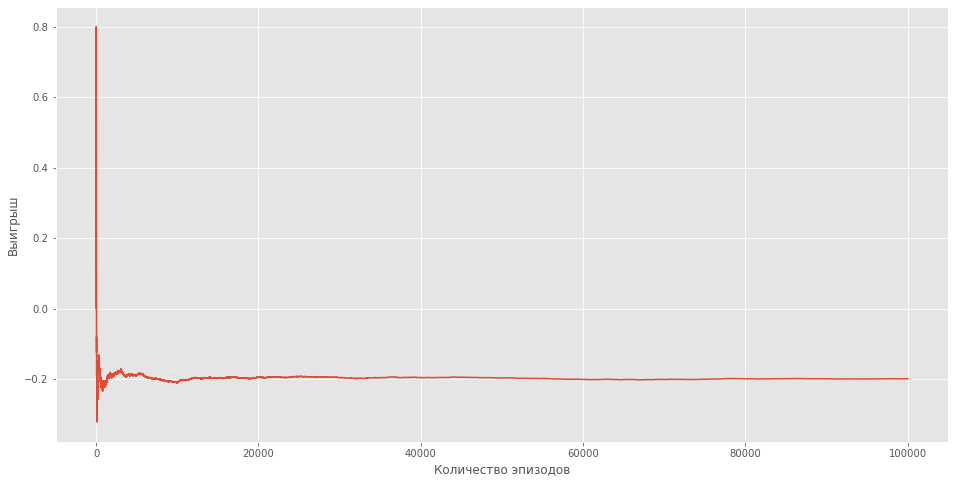

In [5]:
results = []
for i in tqdm(range(len(rewards))):
    results.append(sum(rewards[:i])/(i+1))
plt.figure(figsize=(16, 8))
plt.plot(results)
plt.xlabel('Количество эпизодов')
plt.ylabel('Выигрыш')
plt.grid(True)
plt.show()

По графику видно, что если просто придти поиграть в блекджек, то мы проиграем всё.

2) Реализуйте метод обучения с подкреплением без модели (можно Q-обучение, но рекомендую попробовать и другие, например Monte Carlo control) для обучения стратегии в блекджеке, используя окружение Blackjack-v0 из OpenAI Gym.

In [6]:
class BlackjackEnvDouble(BlackjackEnv):
    def __init__(self, natural=False):
        self.action_space = spaces.Discrete(3)  # Now we have 3 actions instead of 2 (stick=0, hit=1, double=2)
        self.observation_space = spaces.Tuple((
            spaces.Discrete(32),
            spaces.Discrete(11),
            spaces.Discrete(2)))
        self.seed()

        # Flag to payout 1.5 on a "natural" blackjack win, like casino rules
        # Ref: http://www.bicyclecards.com/how-to-play/blackjack/
        self.natural = natural
        # Start the first game
        self.reset()

    def step(self, action):
        assert self.action_space.contains(action)
        if action == 2: # double: add only one card, reward/loss is double.
            done = True
            self.player.append(draw_card(self.np_random))
            if is_bust(self.player):
                reward = -2.
            else:
                while sum_hand(self.dealer) < 17:
                    self.dealer.append(draw_card(self.np_random))
                reward = 2.0 * cmp(score(self.player), score(self.dealer))
            if self.natural and is_natural(self.player) and reward == 2.:
                reward = 3.
            
        elif action == 1:  # hit: add a card to players hand and return
            self.player.append(draw_card(self.np_random))
            if is_bust(self.player):
                done = True
                reward = -1.
            else:
                done = False
                reward = 0.
        else:  # stick: play out the dealers hand, and score
            done = True
            while sum_hand(self.dealer) < 17:
                self.dealer.append(draw_card(self.np_random))
            reward = cmp(score(self.player), score(self.dealer))
            if self.natural and is_natural(self.player) and reward == 1.:
                reward = 1.5
        return self._get_obs(), reward, done, {}

def cmp(a, b):
    return float(a > b) - float(a < b)

# 1 = Ace, 2-10 = Number cards, Jack/Queen/King = 10
deck = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 10, 10, 10]


def draw_card(np_random):
    return int(np_random.choice(deck))


def draw_hand(np_random):
    return [draw_card(np_random), draw_card(np_random)]


def usable_ace(hand):  # Does this hand have a usable ace?
    return 1 in hand and sum(hand) + 10 <= 21


def sum_hand(hand):  # Return current hand total
    if usable_ace(hand):
        return sum(hand) + 10
    return sum(hand)


def is_bust(hand):  # Is this hand a bust?
    return sum_hand(hand) > 21


def score(hand):  # What is the score of this hand (0 if bust)
    return 0 if is_bust(hand) else sum_hand(hand)


def is_natural(hand):  # Is this hand a natural blackjack?
    return sorted(hand) == [1, 10]

In [7]:
class QBlackJack:
    def __init__(self, can_double = False, natural=True):
        self._ph = 32 
        self._dh = 11 
        self._ua = 2
        self._nA = 3 if can_double else 2 
        self._nS = self._ph * self._dh * self._ua 
        if can_double:
            self._env = BlackjackEnvDouble(natural=natural)
        else:
            self._env = gym.make('Blackjack-v1', natural=natural)
    
    def _set_zero_Q(self):
        self._Q = np.zeros(shape=(self._nS, self._nA))
        
    def get_current_policy(self):
        return self._Q.argmax(1)
    
    def _observation_to_idx(self, s):
        return (s[0] - 1) * self._dh * self._ua + (s[1] - 1) * self._ua + s[2]
    
    def idx_to_observation(self, idx):
        s_2 = bool(idx % self._ua)
        idx = (idx - s_2) / self._ua
        s_1 = int(idx % self._dh + 1)
        s_0 = int((idx - (s_1 - 1)) / self._dh + 1)
        return (s_0, s_1, s_2)
    
    def _Q_learning_episode(self, alpha, epsilon, gamma):
        obs = self._env.reset()
        s = self._observation_to_idx(obs)
        pi = self.get_current_policy()
        if np.random.rand() > epsilon:
            a = pi[s]
        else:
            a = np.random.randint(self._nA)
        done = False
        while not done:
            pi = self.get_current_policy()
            observation, reward, done, _ = self._env.step(a)
            s_prime = self._observation_to_idx(observation)
            if np.random.rand() > epsilon:
                a_prime = pi[s_prime]
            else:
                a_prime = np.random.randint(self._nA)
            self._Q[s, a] = self._Q[s, a] + alpha * (reward + gamma * np.max(self._Q[s_prime]) - self._Q[s, a])
            s = s_prime
            if done:
                break
                
    def learn(self, alpha=3e-4, epsilon=0.4, gamma=1.0, n_episodes=100000):
        self._set_zero_Q()
        pi = self.get_current_policy()
        mean_rewards = []
        l_bounds = []
        u_bounds = []
        for i in range(n_episodes):
            self._Q_learning_episode(alpha=alpha, epsilon=epsilon, gamma=gamma)
            pi = self.get_current_policy()
        self.pi = pi
        
    def get_experiment(self, pi=None, n_experiments=200000):
        if not pi:
            pi = self.pi
        rewards = []
        for _ in range(n_experiments):
            observation = self._env.reset()
            s = self._observation_to_idx(observation)
            done = False
            reward = 0
            while not done:
                a = pi[s]
                observation, reward, done, _ = self._env.step(a)
                s = self._observation_to_idx(observation)
            rewards.append(reward)
        return rewards

In [8]:
learner = QBlackJack()
learner.learn(n_episodes=100000)
rewards = learner.get_experiment(n_experiments=100000)

print(f'Средний проигрыш при такой стратегии за {n} экспериментов: {np.mean(rewards)}')

Средний проигрыш при такой стратегии за 100000 экспериментов: -0.07894


3) Сколько выигрывает казино у вашей стратегии? Нарисуйте графики среднего дохода вашего метода (усреднённого по крайней мере по 100000 раздач, а лучше больше) по ходу обучения. Попробуйте подобрать оптимальные гиперпараметры.

100%|████████████████████████████████████████████████████████████████████████| 100000/100000 [00:31<00:00, 3126.96it/s]


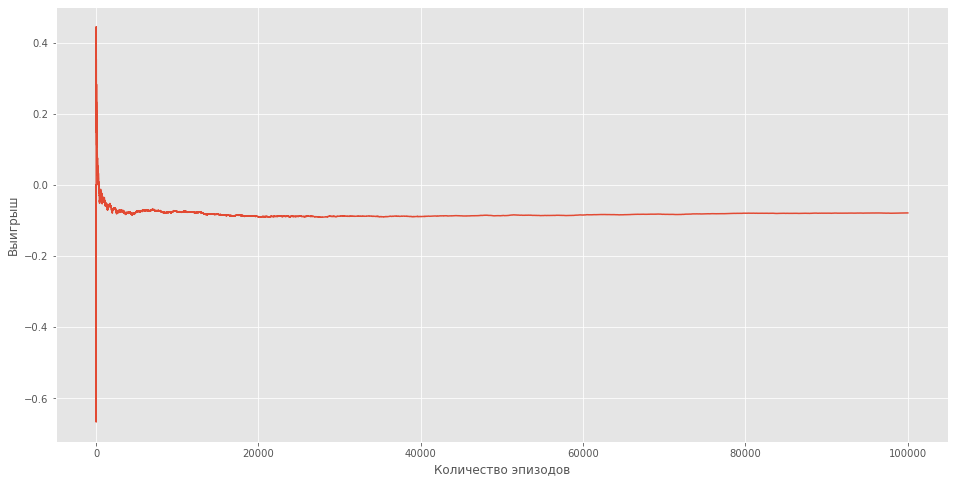

In [9]:
results = []
for i in tqdm(range(len(rewards))):
    results.append(sum(rewards[:i])/(i+1))
plt.figure(figsize=(16, 8))
plt.plot(results)
plt.xlabel('Количество эпизодов')
plt.ylabel('Выигрыш')
plt.grid(True)
plt.show()

In [10]:
epsilons = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
alphas = [1e-5, 3e-5, 1e-4, 3e-4, 1e-3]
k = 10000

params = []
for epsilon in tqdm(epsilons):
    for alpha in alphas:
        learner = QBlackJack()
        learner.learn(n_episodes=k, alpha=alpha, epsilon=epsilon)
        rewards = learner.get_experiment(n_experiments=k)
        params.append([epsilon, alpha, np.mean(rewards)])
        print(f'Epsilon: {epsilon}, Alpha: {alpha}, Result: {np.mean(rewards)}')

  0%|                                                                                            | 0/9 [00:00<?, ?it/s]

Epsilon: 0.1, Alpha: 1e-05, Result: -0.0964
Epsilon: 0.1, Alpha: 3e-05, Result: -0.0761
Epsilon: 0.1, Alpha: 0.0001, Result: -0.0862
Epsilon: 0.1, Alpha: 0.0003, Result: -0.076


 11%|█████████▎                                                                          | 1/9 [00:06<00:48,  6.11s/it]

Epsilon: 0.1, Alpha: 0.001, Result: -0.1076
Epsilon: 0.2, Alpha: 1e-05, Result: -0.0811
Epsilon: 0.2, Alpha: 3e-05, Result: -0.11
Epsilon: 0.2, Alpha: 0.0001, Result: -0.0906
Epsilon: 0.2, Alpha: 0.0003, Result: -0.0966


 22%|██████████████████▋                                                                 | 2/9 [00:12<00:42,  6.10s/it]

Epsilon: 0.2, Alpha: 0.001, Result: -0.0836
Epsilon: 0.3, Alpha: 1e-05, Result: -0.0684
Epsilon: 0.3, Alpha: 3e-05, Result: -0.069
Epsilon: 0.3, Alpha: 0.0001, Result: -0.0633
Epsilon: 0.3, Alpha: 0.0003, Result: -0.0929


 33%|████████████████████████████                                                        | 3/9 [00:18<00:36,  6.06s/it]

Epsilon: 0.3, Alpha: 0.001, Result: -0.0622
Epsilon: 0.4, Alpha: 1e-05, Result: -0.0802
Epsilon: 0.4, Alpha: 3e-05, Result: -0.0913
Epsilon: 0.4, Alpha: 0.0001, Result: -0.0719
Epsilon: 0.4, Alpha: 0.0003, Result: -0.091


 44%|█████████████████████████████████████▎                                              | 4/9 [00:24<00:30,  6.05s/it]

Epsilon: 0.4, Alpha: 0.001, Result: -0.0837
Epsilon: 0.5, Alpha: 1e-05, Result: -0.0936
Epsilon: 0.5, Alpha: 3e-05, Result: -0.077
Epsilon: 0.5, Alpha: 0.0001, Result: -0.0594
Epsilon: 0.5, Alpha: 0.0003, Result: -0.0897


 56%|██████████████████████████████████████████████▋                                     | 5/9 [00:30<00:24,  6.07s/it]

Epsilon: 0.5, Alpha: 0.001, Result: -0.0845
Epsilon: 0.6, Alpha: 1e-05, Result: -0.0732
Epsilon: 0.6, Alpha: 3e-05, Result: -0.0897
Epsilon: 0.6, Alpha: 0.0001, Result: -0.1018
Epsilon: 0.6, Alpha: 0.0003, Result: -0.094


 67%|████████████████████████████████████████████████████████                            | 6/9 [00:36<00:18,  6.08s/it]

Epsilon: 0.6, Alpha: 0.001, Result: -0.0941
Epsilon: 0.7, Alpha: 1e-05, Result: -0.082
Epsilon: 0.7, Alpha: 3e-05, Result: -0.0948
Epsilon: 0.7, Alpha: 0.0001, Result: -0.0672
Epsilon: 0.7, Alpha: 0.0003, Result: -0.0773


 78%|█████████████████████████████████████████████████████████████████▎                  | 7/9 [00:42<00:12,  6.10s/it]

Epsilon: 0.7, Alpha: 0.001, Result: -0.083
Epsilon: 0.8, Alpha: 1e-05, Result: -0.0711
Epsilon: 0.8, Alpha: 3e-05, Result: -0.0749
Epsilon: 0.8, Alpha: 0.0001, Result: -0.0718
Epsilon: 0.8, Alpha: 0.0003, Result: -0.0759


 89%|██████████████████████████████████████████████████████████████████████████▋         | 8/9 [00:48<00:06,  6.10s/it]

Epsilon: 0.8, Alpha: 0.001, Result: -0.0887
Epsilon: 0.9, Alpha: 1e-05, Result: -0.0886
Epsilon: 0.9, Alpha: 3e-05, Result: -0.0822
Epsilon: 0.9, Alpha: 0.0001, Result: -0.0842
Epsilon: 0.9, Alpha: 0.0003, Result: -0.083


100%|████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:54<00:00,  6.09s/it]

Epsilon: 0.9, Alpha: 0.001, Result: -0.0796


In [11]:
best_params = max(params, key=lambda x: x[2])
print("""Best params:
Epsilon: {}
Alpha: {}
Result: {}""".format(*best_params))

Best params:
Epsilon: 0.5
Alpha: 0.0001
Result: -0.0594


In [12]:
learner = QBlackJack()
learner.learn(n_episodes=n, epsilon=best_params[0], alpha=best_params[1])
rewards = learner.get_experiment(n_experiments=n)

print(f'Средний проигрыш при такой стратегии за {n} экспериментов: {np.mean(rewards)}')

Средний проигрыш при такой стратегии за 100000 экспериментов: -0.06506


100%|████████████████████████████████████████████████████████████████████████| 100000/100000 [00:30<00:00, 3328.93it/s]


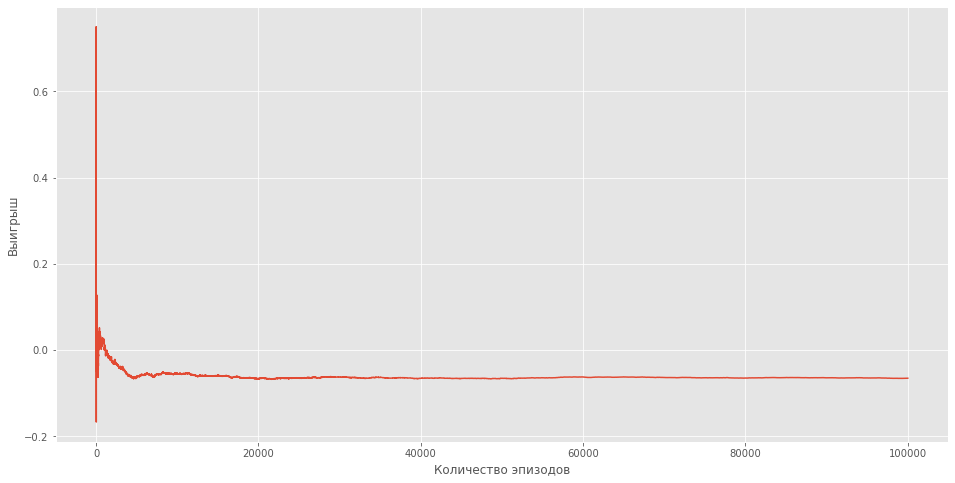

In [13]:
results = []
for i in tqdm(range(len(rewards))):
    results.append(sum(rewards[:i])/(i+1))
plt.figure(figsize=(16, 8))
plt.plot(results)
plt.xlabel('Количество эпизодов')
plt.ylabel('Выигрыш')
plt.grid(True)
plt.show()

Результаты улучшились, намного меньше проигрываем при использовании Q-алгоритма, но все равно не можем победить, так как не учитываем опыт предыдущих раздач.

## Часть вторая, удвоенная
В базовый блекджек, описанный в предыдущем разделе, обыграть казино вряд ли получится. Но, к счастью, на этом история не заканчивается. Описанные выше правила были упрощёнными, а на самом деле у игрока есть ещё и другие возможности. Реализовывать split может оказаться непросто, поэтому давайте ограничимся удвоением ставки. Итак, у игрока появляется дополнительное действие:

double — удвоить ставку; при этом больше действий делать нельзя, игроку выдаётся ровно одна дополнительная карта, а выигрыш или проигрыш удваивается.

4) Реализуйте новый вариант блекджека на основе окружения Blackjack-v0 из OpenAI Gym, в котором разрешено удвоение ставки.

5) Реализуйте метод обучения с подкреплением без модели для этого варианта, постройте графики, аналогичные п.2.

In [14]:
learner = QBlackJack(can_double=True)
learner.learn(n_episodes=n)
rewards = learner.get_experiment(n_experiments=n)

print(f'Средний проигрыш при такой стратегии за {n} экспериментов: {np.mean(rewards)}')

Средний проигрыш при такой стратегии за 100000 экспериментов: -0.12368


100%|████████████████████████████████████████████████████████████████████████| 100000/100000 [00:30<00:00, 3331.64it/s]


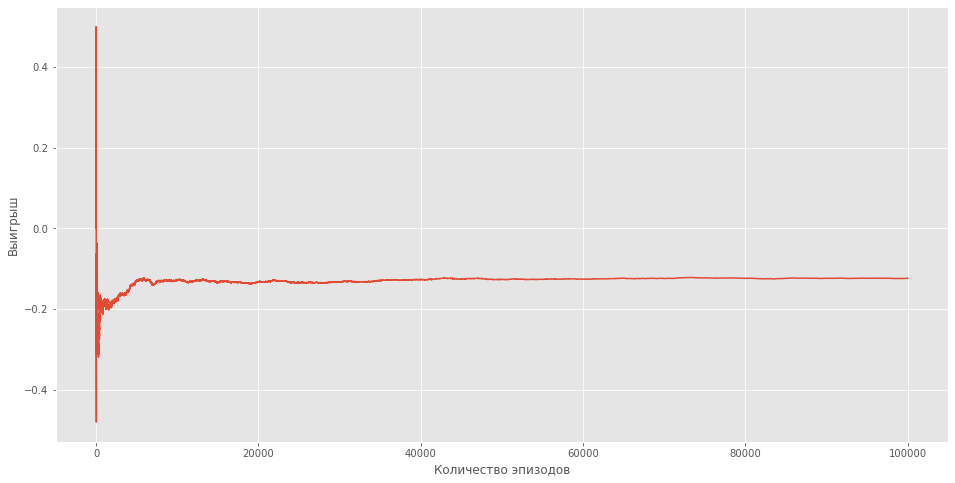

In [15]:
results = []
for i in tqdm(range(len(rewards))):
    results.append(sum(rewards[:i])/(i+1))
plt.figure(figsize=(16, 8))
plt.plot(results)
plt.xlabel('Количество эпизодов')
plt.ylabel('Выигрыш')
plt.grid(True)
plt.show()

In [16]:
epsilons = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
alphas = [1e-5, 3e-5, 1e-4, 3e-4, 1e-3]
k = 10000

params = []
for epsilon in tqdm(epsilons):
    for alpha in alphas:
        learner = QBlackJack(can_double=True)
        learner.learn(n_episodes=k, alpha=alpha, epsilon=epsilon)
        rewards = learner.get_experiment(n_experiments=k)
        params.append([epsilon, alpha, np.mean(rewards)])
        print(f'Epsilon: {epsilon}, Alpha: {alpha}, Result: {np.mean(rewards)}')

  0%|                                                                                            | 0/9 [00:00<?, ?it/s]

Epsilon: 0.1, Alpha: 1e-05, Result: -0.0947
Epsilon: 0.1, Alpha: 3e-05, Result: -0.13725
Epsilon: 0.1, Alpha: 0.0001, Result: -0.17765
Epsilon: 0.1, Alpha: 0.0003, Result: -0.16335


 11%|█████████▎                                                                          | 1/9 [00:06<00:48,  6.08s/it]

Epsilon: 0.1, Alpha: 0.001, Result: -0.1482
Epsilon: 0.2, Alpha: 1e-05, Result: -0.1515
Epsilon: 0.2, Alpha: 3e-05, Result: -0.1293
Epsilon: 0.2, Alpha: 0.0001, Result: -0.1472
Epsilon: 0.2, Alpha: 0.0003, Result: -0.1065


 22%|██████████████████▋                                                                 | 2/9 [00:12<00:42,  6.07s/it]

Epsilon: 0.2, Alpha: 0.001, Result: -0.13915
Epsilon: 0.3, Alpha: 1e-05, Result: -0.14085
Epsilon: 0.3, Alpha: 3e-05, Result: -0.1621
Epsilon: 0.3, Alpha: 0.0001, Result: -0.14285
Epsilon: 0.3, Alpha: 0.0003, Result: -0.086


 33%|████████████████████████████                                                        | 3/9 [00:18<00:36,  6.09s/it]

Epsilon: 0.3, Alpha: 0.001, Result: -0.1352
Epsilon: 0.4, Alpha: 1e-05, Result: -0.0796
Epsilon: 0.4, Alpha: 3e-05, Result: -0.11865
Epsilon: 0.4, Alpha: 0.0001, Result: -0.08825
Epsilon: 0.4, Alpha: 0.0003, Result: -0.13855


 44%|█████████████████████████████████████▎                                              | 4/9 [00:24<00:30,  6.10s/it]

Epsilon: 0.4, Alpha: 0.001, Result: -0.1238
Epsilon: 0.5, Alpha: 1e-05, Result: -0.12955
Epsilon: 0.5, Alpha: 3e-05, Result: -0.15025
Epsilon: 0.5, Alpha: 0.0001, Result: -0.08795
Epsilon: 0.5, Alpha: 0.0003, Result: -0.0922


 56%|██████████████████████████████████████████████▋                                     | 5/9 [00:30<00:24,  6.11s/it]

Epsilon: 0.5, Alpha: 0.001, Result: -0.1052
Epsilon: 0.6, Alpha: 1e-05, Result: -0.1133
Epsilon: 0.6, Alpha: 3e-05, Result: -0.11225
Epsilon: 0.6, Alpha: 0.0001, Result: -0.0895
Epsilon: 0.6, Alpha: 0.0003, Result: -0.10595


 67%|████████████████████████████████████████████████████████                            | 6/9 [00:36<00:18,  6.08s/it]

Epsilon: 0.6, Alpha: 0.001, Result: -0.0825
Epsilon: 0.7, Alpha: 1e-05, Result: -0.073
Epsilon: 0.7, Alpha: 3e-05, Result: -0.118
Epsilon: 0.7, Alpha: 0.0001, Result: -0.08855
Epsilon: 0.7, Alpha: 0.0003, Result: -0.1027


 78%|█████████████████████████████████████████████████████████████████▎                  | 7/9 [00:42<00:12,  6.07s/it]

Epsilon: 0.7, Alpha: 0.001, Result: -0.1097
Epsilon: 0.8, Alpha: 1e-05, Result: -0.0954
Epsilon: 0.8, Alpha: 3e-05, Result: -0.0848
Epsilon: 0.8, Alpha: 0.0001, Result: -0.04045
Epsilon: 0.8, Alpha: 0.0003, Result: -0.1036


 89%|██████████████████████████████████████████████████████████████████████████▋         | 8/9 [00:48<00:06,  6.06s/it]

Epsilon: 0.8, Alpha: 0.001, Result: -0.07045
Epsilon: 0.9, Alpha: 1e-05, Result: -0.06925
Epsilon: 0.9, Alpha: 3e-05, Result: -0.1003
Epsilon: 0.9, Alpha: 0.0001, Result: -0.0562
Epsilon: 0.9, Alpha: 0.0003, Result: -0.0884


100%|████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:54<00:00,  6.07s/it]

Epsilon: 0.9, Alpha: 0.001, Result: -0.0658


In [17]:
best_params = max(params, key=lambda x: x[2])
print("""Best params:
Epsilon: {}
Alpha: {}
Result: {}""".format(*best_params))

Best params:
Epsilon: 0.8
Alpha: 0.0001
Result: -0.04045


In [18]:
learner = QBlackJack(can_double=True)
learner.learn(n_episodes=n, epsilon=best_params[0], alpha=best_params[1])
rewards = learner.get_experiment(n_experiments=n)

print(f'Средний проигрыш при такой стратегии за {n} экспериментов: {np.mean(rewards)}')

Средний проигрыш при такой стратегии за 100000 экспериментов: -0.03519


100%|████████████████████████████████████████████████████████████████████████| 100000/100000 [00:30<00:00, 3228.00it/s]


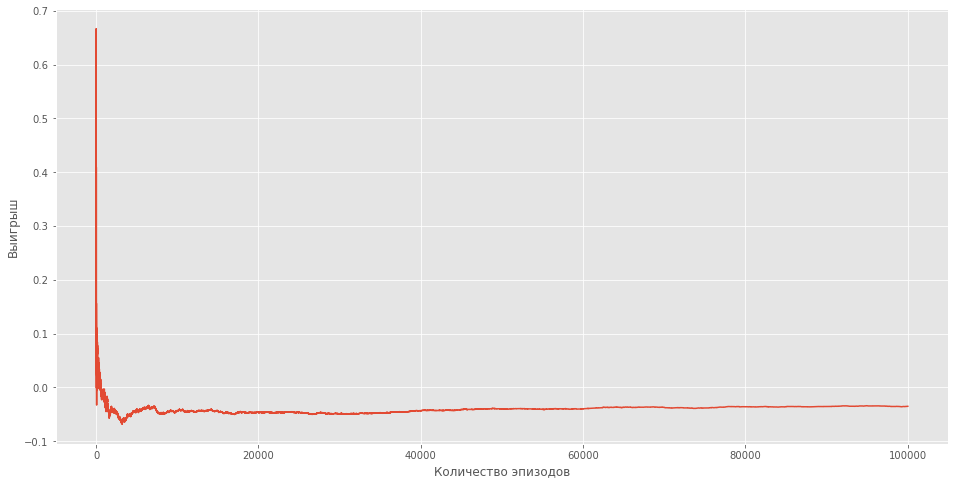

In [19]:
results = []
for i in tqdm(range(len(rewards))):
    results.append(sum(rewards[:i])/(i+1))
plt.figure(figsize=(16, 8))
plt.plot(results)
plt.xlabel('Количество эпизодов')
plt.ylabel('Выигрыш')
plt.grid(True)
plt.show()

Если играть с удвоением, то на первых 20000 иттерациях появляется возможность выигрыша, но этого не происходит и обыграть казино не получается.

## Часть третья, в главной роли — Дастин Хоффман
А теперь давайте вспомним, как играют в блекджек настоящие профессионалы. Дело в том, что в оффлайн-казино обычно не перемешивают колоду после каждой раздачи — это слишком замедляло бы игру. После раздачи карты просто раздаются дальше с верха колоды до тех пор, пока карт не останется слишком мало, и только тогда колода перемешивается; давайте для определённости считать, что наше казино будет перемешивать колоду, в которой осталось меньше 15 карт.

Действительно, если вы будете запоминать, какие карты уже вышли, у вас будет информация о том, какие карты ещё остались, а это позволяет лучше понять, когда нужно удваивать ставку или делать split, а когда лучше не стоит. В настоящем казино могут раздавать карты сразу из нескольких колод, и заслуга Rain Man’а была в том, что он смог считать карты в шести колодах одновременно. Но мы с вами вооружены компьютерами, так что подсчёт можно считать автоматическим.

6) Реализуйте вариант окружения Blackjack-v0 из предыдущей части (с удвоением), в котором игрок имеет возможность “считать карты” в колоде. Это можно сделать разными способами; возможно, вам поможет статья википедии о блекджеке (а возможно, и нет).

7) Реализуйте метод обучения с подкреплением без модели для этого варианта, постройте графики, аналогичные п.2.



In [20]:
class BlackjackCardCountCardsEnv(BlackjackEnv):
    def __init__(self, natural=False):
        self.action_space = spaces.Discrete(3)  # Now we have 3 actions instead of 2 (stick=0, hit=1, double=2)
        self.observation_space = spaces.Tuple((
            spaces.Discrete(32),
            spaces.Discrete(11),
            spaces.Discrete(2),
            spaces.Discrete(21))),
        self.seed()
        
        self.dealer = []
        self.player = []
        
        self.get_new_deck()

        # Flag to payout 1.5 on a "natural" blackjack win, like casino rules
        # Ref: http://www.bicyclecards.com/how-to-play/blackjack/
        self.natural = natural
        
    def _get_obs(self):
        return (sum_hand(self.player), self.dealer[0], usable_ace(self.player), self.get_deck_status())
    
    def get_deck_status(self):
        status = self.current_deck
        if status < -10:
            status = -10
        elif status > 10:
            status = 10
        return status + 10

    def get_new_deck(self):
        self.deck = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 10, 10, 10] * 4
        random.shuffle(self.deck)
        self.current_deck = 0
        self.not_relevant_dealer_cards = len(self.dealer)
    
    def start_new_game(self):
        self.dealer = []
        self.dealer.append(self.get_card())
        self.dealer.append(self.get_card(visible=False))
        self.not_relevant_dealer_cards = 1
        
        self.player = []
        self.player.append(self.get_card())
        self.player.append(self.get_card())
        return self._get_obs()
    
    def get_card(self, visible=True):
        card = self.deck.pop()
        if visible:
            self.current_deck += get_card_value(card)
        if len(self.deck) < 15:
            self.get_new_deck()
        return card
    
    def step(self, action):
        assert self.action_space.contains(action)
        if action == 2: # double: add only one card, reward/loss is double.
            done = True
            self.player.append(self.get_card())
            if is_bust(self.player):
                reward = -2.
            else:
                while sum_hand(self.dealer) < 17:
                    self.dealer.append(self.get_card(visible=False))
                reward = 2.0 * cmp(score(self.player), score(self.dealer))
            if self.natural and is_natural(self.player) and reward == 2.:
                reward = 3.
            
        elif action == 1:  
            self.player.append(self.get_card())
            if is_bust(self.player):
                done = True
                reward = -1.
            else:
                done = False
                reward = 0.
        else:  
            done = True
            while sum_hand(self.dealer) < 17:
                self.dealer.append(self.get_card(visible=False)) 
            reward = cmp(score(self.player), score(self.dealer))
            if self.natural and is_natural(self.player) and reward == 1.:
                reward = 1.5
        if done: 
            for card in self.dealer[self.not_relevant_dealer_cards:]:
                self.current_deck += get_card_value(card)
        return self._get_obs(), reward, done, {}

def cmp(a, b):
    return float(a > b) - float(a < b)


def usable_ace(hand):  # Does this hand have a usable ace?
    return 1 in hand and sum(hand) + 10 <= 21


def sum_hand(hand):  
    if usable_ace(hand):
        return sum(hand) + 10
    return sum(hand)


def is_bust(hand): 
    return sum_hand(hand) > 21


def score(hand): 
    return 0 if is_bust(hand) else sum_hand(hand)


def is_natural(hand):  
    return sorted(hand) == [1, 10]

def get_card_value(card): 
    if card in [2, 3, 4, 5, 6]:
        return 1
    elif card in [1, 10]:
        return  -1
    return 0

In [21]:
class QBlackJackCardCounter(QBlackJack):
    def __init__(self, natural=True):
        self._ph = 32 
        self._dh = 11 
        self._ua = 2 
        self._ds = 21 
        self._nA = 3 
        self._nS = self._ph * self._dh * self._ua * self._ds # nS
        self._env = BlackjackCardCountCardsEnv(natural=natural)
        self._env.reset()
    
    def _observation_to_idx(self, s):
        return (s[0] - 1) * self._dh * self._ua * self._ds + (s[1] - 1) * self._ua * self._ds + s[2] * self._ds + s[3]
    
    def idx_to_observation(self, idx):
        s_3 = int(idx % self._ds)
        idx = (idx - s_3) / self._ds
        s_2 = bool(idx % self._ua)
        idx = (idx - s_2) / self._ua
        s_1 = int(idx % self._dh + 1)
        s_0 = int((idx - (s_1 - 1)) / self._dh + 1)
        return (s_0, s_1, s_2, s_3)
    
    def _Q_learning_episode(self, alpha, epsilon, gamma):
        obs = self._env.start_new_game()
        s = self._observation_to_idx(obs)
        pi = self.get_current_policy()
        if np.random.rand() > epsilon:
            a = pi[s]
        else:
            a = np.random.randint(self._nA)
        done = False
        while not done:
            pi = self.get_current_policy()
            observation, reward, done, _ = self._env.step(a)
            s_prime = self._observation_to_idx(observation)
            if np.random.rand() > epsilon:
                a_prime = pi[s_prime]
            else:
                a_prime = np.random.randint(self._nA)
            self._Q[s, a] = self._Q[s, a] + alpha * (reward + gamma * np.max(self._Q[s_prime]) - self._Q[s, a])
            s = s_prime
            if done:
                break
        
    def get_experiment(self, pi=None, n_experiments=100000):
        if not pi:
            pi = self.pi
        rewards = []
        for _ in range(n_experiments):
            observation = self._env.start_new_game()
            s = self._observation_to_idx(observation)
            done = False
            reward = 0
            while not done:
                a = pi[s]
                observation, reward, done, _ = self._env.step(a)
                s = self._observation_to_idx(observation)
            rewards.append(reward)
        return rewards

In [22]:
learner = QBlackJackCardCounter()
learner.learn(n_episodes=n)
rewards = learner.get_experiment(n_experiments=n)

print(f'Средний проигрыш при такой стратегии за {n} экспериментов: {np.mean(rewards)}')

Средний проигрыш при такой стратегии за 100000 экспериментов: -0.118775


100%|████████████████████████████████████████████████████████████████████████| 100000/100000 [00:29<00:00, 3351.94it/s]


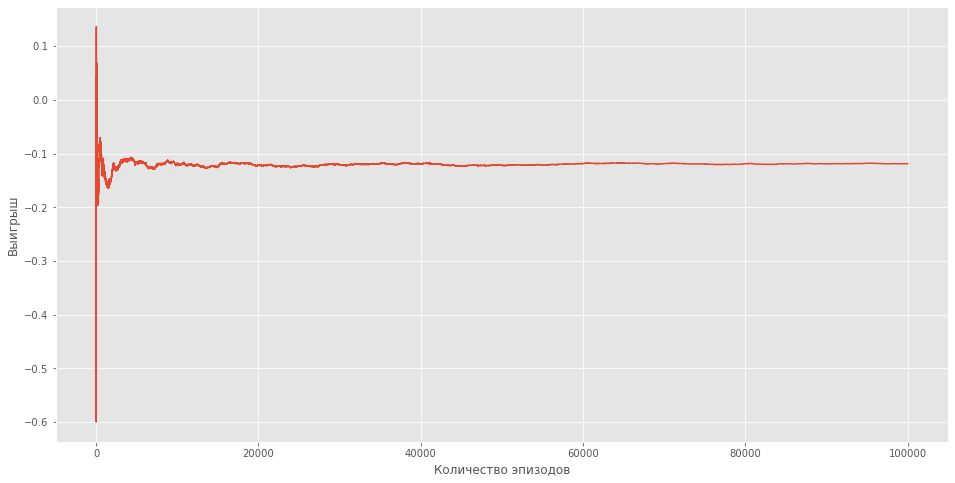

In [23]:
results = []
for i in tqdm(range(len(rewards))):
    results.append(sum(rewards[:i])/(i+1))
plt.figure(figsize=(16, 8))
plt.plot(results)
plt.xlabel('Количество эпизодов')
plt.ylabel('Выигрыш')
plt.grid(True)
plt.show()

Стратегия с подсчетом карт оказалась хуже, чем предыдущая стратегия, на основе усредненного выигрыша (проигрыша), так как увеличилось количество состояний и требуется намного больше итераций, чтобы обучить алгоритм. Но даже с этим нет надежды на победу над казино.